In [1]:
!pip install sentence-transformers

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable


In [3]:


from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import torch
import random
import torch

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [4]:
#Load the sprag dataset
data = pd.read_csv("refstdcombined.csv")
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0


In [5]:
data = data.dropna()

In [6]:
#### Just some code to print debug information to stdout
import logging
from sentence_transformers import LoggingHandler
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

In [7]:
from sklearn.model_selection import train_test_split

# Storing labels in array
labels = data['max_score'].values

# Dropping labels column from data
data = data.drop(['max_score'], axis=1)

# Splitting data into train and test sets in a 70/30 ratio
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, random_state=42, test_size=0.2)

In [8]:
def sentence_pairs_generation(sentence1, sentence2, labels, pairs):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if the grade of the pair

  numClassesList = np.unique(labels)
  #print(numClassesList)
  idx = [np.where(labels == i)[0] for i in numClassesList]
  #print(idx)

  for idxA in range(len(sentence1)):      
    dAns = sentence1[idxA]
    sAns = sentence2[idxA]
    label = int(labels[idxA])
    
		  # prepare a pair and update the sentences and labels lists, respectively
    pairs.append(InputExample(texts=[dAns, sAns], label=label))

     
	# return a 2-tuple of our image pairs and labels
  return (pairs)

In [9]:
set_seed(0)
# Equal samples per class training
#train_df_sample = pd.concat([train_df[train_df[1]==0].sample(num_training), train_df[train_df[1]==1].sample(num_training)])
x_train_dA = train_data['ReferenceAnswer'].values.tolist()
x_train_sA = train_data['StudentAnswer'].values.tolist()
y_train = train_labels.tolist()
y_train = [int(x) for x in y_train]

In [10]:
#use test dataset as dev dataset
x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels / 5.0
y_test = test_labels.tolist()
#y_test = [int(x) for x in y_test]

test_examples = [] 
test_examples = sentence_pairs_generation(np.array(x_test_dA), np.array(x_test_sA), np.array(y_test), test_examples)

In [11]:
train_examples = [] 
train_examples = sentence_pairs_generation(np.array(x_train_dA), np.array(x_train_sA), np.array(y_train), train_examples)

In [12]:
# Save path of the model
from datetime import datetime
model_save_path = 'output/training_sprag_v2_'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [14]:
from sentence_transformers import evaluation
import math

def train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs,model_save_path):
  model = SentenceTransformer(st_model)
  #for evaluation
  train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
  test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')

  #configuring the training
  warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
  print(warmup_steps)
  #train_loss = losses.CosineSimilarityLoss(model)
  model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=test_evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          show_progress_bar=True,  
          #evaluation_steps=50, 
          output_path=model_save_path,)
  print("Training done...")

###Training - 1
#### stsb-distilbert-base

In [14]:
st_model = 'stsb-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "multi_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 22:22:07 - Load pretrained SentenceTransformer: stsb-distilbert-base
2022-07-18 22:22:08 - Use pytorch device: cuda
2022-07-18 22:22:08 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:22:27 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 0:
2022-07-18 22:22:28 - Cosine-Similarity :	Pearson: 0.6300	Spearman: 0.6403
2022-07-18 22:22:28 - Manhattan-Distance:	Pearson: 0.6199	Spearman: 0.6437
2022-07-18 22:22:28 - Euclidean-Distance:	Pearson: 0.6191	Spearman: 0.6421
2022-07-18 22:22:28 - Dot-Product-Similarity:	Pearson: 0.6218	Spearman: 0.6292
2022-07-18 22:22:28 - Save model to multi_sim_output/stsb-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:22:45 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 1:
2022-07-18 22:22:46 - Cosine-Similarity :	Pearson: 0.7026	Spearman: 0.7278
2022-07-18 22:22:46 - Manhattan-Distance:	Pearson: 0.6869	Spearman: 0.7276
2022-07-18 22:22:46 - Euclidean-Distance:	Pearson: 0.6873	Spearman: 0.7276
2022-07-18 22:22:46 - Dot-Product-Similarity:	Pearson: 0.6999	Spearman: 0.7240
2022-07-18 22:22:46 - Save model to multi_sim_output/stsb-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:23:02 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 2:
2022-07-18 22:23:04 - Cosine-Similarity :	Pearson: 0.7271	Spearman: 0.7507
2022-07-18 22:23:04 - Manhattan-Distance:	Pearson: 0.7131	Spearman: 0.7502
2022-07-18 22:23:04 - Euclidean-Distance:	Pearson: 0.7138	Spearman: 0.7503
2022-07-18 22:23:04 - Dot-Product-Similarity:	Pearson: 0.7262	Spearman: 0.7489
2022-07-18 22:23:04 - Save model to multi_sim_output/stsb-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:23:20 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 3:
2022-07-18 22:23:22 - Cosine-Similarity :	Pearson: 0.7307	Spearman: 0.7572
2022-07-18 22:23:22 - Manhattan-Distance:	Pearson: 0.7152	Spearman: 0.7573
2022-07-18 22:23:22 - Euclidean-Distance:	Pearson: 0.7155	Spearman: 0.7570
2022-07-18 22:23:22 - Dot-Product-Similarity:	Pearson: 0.7307	Spearman: 0.7569
2022-07-18 22:23:22 - Save model to multi_sim_output/stsb-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:23:38 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 4:
2022-07-18 22:23:40 - Cosine-Similarity :	Pearson: 0.7398	Spearman: 0.7650
2022-07-18 22:23:40 - Manhattan-Distance:	Pearson: 0.7205	Spearman: 0.7649
2022-07-18 22:23:40 - Euclidean-Distance:	Pearson: 0.7204	Spearman: 0.7643
2022-07-18 22:23:40 - Dot-Product-Similarity:	Pearson: 0.7396	Spearman: 0.7650
2022-07-18 22:23:40 - Save model to multi_sim_output/stsb-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:23:57 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 5:
2022-07-18 22:23:58 - Cosine-Similarity :	Pearson: 0.7361	Spearman: 0.7661
2022-07-18 22:23:58 - Manhattan-Distance:	Pearson: 0.7120	Spearman: 0.7655
2022-07-18 22:23:58 - Euclidean-Distance:	Pearson: 0.7122	Spearman: 0.7651
2022-07-18 22:23:58 - Dot-Product-Similarity:	Pearson: 0.7356	Spearman: 0.7657
2022-07-18 22:23:58 - Save model to multi_sim_output/stsb-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:24:15 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 6:
2022-07-18 22:24:17 - Cosine-Similarity :	Pearson: 0.7274	Spearman: 0.7600
2022-07-18 22:24:17 - Manhattan-Distance:	Pearson: 0.7121	Spearman: 0.7605
2022-07-18 22:24:17 - Euclidean-Distance:	Pearson: 0.7118	Spearman: 0.7596
2022-07-18 22:24:17 - Dot-Product-Similarity:	Pearson: 0.7277	Spearman: 0.7602


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:24:33 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 7:
2022-07-18 22:24:34 - Cosine-Similarity :	Pearson: 0.7154	Spearman: 0.7509
2022-07-18 22:24:34 - Manhattan-Distance:	Pearson: 0.6964	Spearman: 0.7519
2022-07-18 22:24:34 - Euclidean-Distance:	Pearson: 0.6966	Spearman: 0.7516
2022-07-18 22:24:34 - Dot-Product-Similarity:	Pearson: 0.7153	Spearman: 0.7502


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:24:50 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 8:
2022-07-18 22:24:51 - Cosine-Similarity :	Pearson: 0.7072	Spearman: 0.7446
2022-07-18 22:24:51 - Manhattan-Distance:	Pearson: 0.6898	Spearman: 0.7459
2022-07-18 22:24:51 - Euclidean-Distance:	Pearson: 0.6898	Spearman: 0.7460
2022-07-18 22:24:51 - Dot-Product-Similarity:	Pearson: 0.7072	Spearman: 0.7447


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:25:07 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 9:
2022-07-18 22:25:08 - Cosine-Similarity :	Pearson: 0.7000	Spearman: 0.7388
2022-07-18 22:25:08 - Manhattan-Distance:	Pearson: 0.6828	Spearman: 0.7403
2022-07-18 22:25:08 - Euclidean-Distance:	Pearson: 0.6830	Spearman: 0.7408
2022-07-18 22:25:08 - Dot-Product-Similarity:	Pearson: 0.7000	Spearman: 0.7388
Training done...



                     ********** stsb-distilbert-base **********
2022-07-18 22:25:08 - Load pretrained SentenceTransformer: multi_sim_output/stsb-distilbert-base
2022-07-18 22:25:09 - Use pytorch device: cuda
2022-07-18 22:25:09 - Softmax loss: #Vectors concatenated: 3
2022-07-18 22:25:09 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 22:25:10 - Cosine-Similarity :	Pearson: 0.7361	Spearman: 0.7661
2022-07-18 22:25:10 - Manhattan-Distance:	Pearson: 0.7120	Spearman: 0.7655
2022-07-18 22:25:10 - Euclidean-Distance:	Pearson: 

0.15087281795511223

### Experiment-2
####all-MiniLM-L6-v2

In [15]:
st_model = 'sentence-transformers/all-MiniLM-L6-v2'
num_epochs = 10
batch_size=16
model_save_path = "multi_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 22:25:21 - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2022-07-18 22:25:21 - Use pytorch device: cuda
2022-07-18 22:25:21 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:25:36 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 0:
2022-07-18 22:25:37 - Cosine-Similarity :	Pearson: 0.6006	Spearman: 0.6546
2022-07-18 22:25:37 - Manhattan-Distance:	Pearson: 0.6285	Spearman: 0.6542
2022-07-18 22:25:37 - Euclidean-Distance:	Pearson: 0.6290	Spearman: 0.6546
2022-07-18 22:25:37 - Dot-Product-Similarity:	Pearson: 0.6006	Spearman: 0.6546
2022-07-18 22:25:37 - Save model to multi_sim_output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:25:53 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 1:
2022-07-18 22:25:54 - Cosine-Similarity :	Pearson: 0.6131	Spearman: 0.6581
2022-07-18 22:25:54 - Manhattan-Distance:	Pearson: 0.6150	Spearman: 0.6561
2022-07-18 22:25:54 - Euclidean-Distance:	Pearson: 0.6150	Spearman: 0.6581
2022-07-18 22:25:54 - Dot-Product-Similarity:	Pearson: 0.6131	Spearman: 0.6581
2022-07-18 22:25:54 - Save model to multi_sim_output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:26:09 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 2:
2022-07-18 22:26:11 - Cosine-Similarity :	Pearson: 0.6220	Spearman: 0.6690
2022-07-18 22:26:11 - Manhattan-Distance:	Pearson: 0.6312	Spearman: 0.6708
2022-07-18 22:26:11 - Euclidean-Distance:	Pearson: 0.6290	Spearman: 0.6690
2022-07-18 22:26:11 - Dot-Product-Similarity:	Pearson: 0.6220	Spearman: 0.6690
2022-07-18 22:26:11 - Save model to multi_sim_output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:26:26 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 3:
2022-07-18 22:26:27 - Cosine-Similarity :	Pearson: 0.6210	Spearman: 0.6689
2022-07-18 22:26:27 - Manhattan-Distance:	Pearson: 0.6286	Spearman: 0.6768
2022-07-18 22:26:27 - Euclidean-Distance:	Pearson: 0.6199	Spearman: 0.6689
2022-07-18 22:26:27 - Dot-Product-Similarity:	Pearson: 0.6210	Spearman: 0.6689
2022-07-18 22:26:27 - Save model to multi_sim_output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:26:43 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 4:
2022-07-18 22:26:44 - Cosine-Similarity :	Pearson: 0.5979	Spearman: 0.6409
2022-07-18 22:26:44 - Manhattan-Distance:	Pearson: 0.6134	Spearman: 0.6551
2022-07-18 22:26:44 - Euclidean-Distance:	Pearson: 0.6007	Spearman: 0.6409
2022-07-18 22:26:44 - Dot-Product-Similarity:	Pearson: 0.5979	Spearman: 0.6409


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:26:59 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 5:
2022-07-18 22:27:00 - Cosine-Similarity :	Pearson: 0.5875	Spearman: 0.6308
2022-07-18 22:27:00 - Manhattan-Distance:	Pearson: 0.5979	Spearman: 0.6445
2022-07-18 22:27:00 - Euclidean-Distance:	Pearson: 0.5815	Spearman: 0.6307
2022-07-18 22:27:00 - Dot-Product-Similarity:	Pearson: 0.5875	Spearman: 0.6308


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:27:15 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 6:
2022-07-18 22:27:17 - Cosine-Similarity :	Pearson: 0.5689	Spearman: 0.6036
2022-07-18 22:27:17 - Manhattan-Distance:	Pearson: 0.5871	Spearman: 0.6290
2022-07-18 22:27:17 - Euclidean-Distance:	Pearson: 0.5678	Spearman: 0.6036
2022-07-18 22:27:17 - Dot-Product-Similarity:	Pearson: 0.5689	Spearman: 0.6036


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:27:32 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 7:
2022-07-18 22:27:34 - Cosine-Similarity :	Pearson: 0.5884	Spearman: 0.6245
2022-07-18 22:27:34 - Manhattan-Distance:	Pearson: 0.6055	Spearman: 0.6472
2022-07-18 22:27:34 - Euclidean-Distance:	Pearson: 0.5858	Spearman: 0.6245
2022-07-18 22:27:34 - Dot-Product-Similarity:	Pearson: 0.5884	Spearman: 0.6245


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:27:48 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 8:
2022-07-18 22:27:50 - Cosine-Similarity :	Pearson: 0.5816	Spearman: 0.6176
2022-07-18 22:27:50 - Manhattan-Distance:	Pearson: 0.5991	Spearman: 0.6448
2022-07-18 22:27:50 - Euclidean-Distance:	Pearson: 0.5779	Spearman: 0.6176
2022-07-18 22:27:50 - Dot-Product-Similarity:	Pearson: 0.5816	Spearman: 0.6176


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:28:05 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 9:
2022-07-18 22:28:06 - Cosine-Similarity :	Pearson: 0.5697	Spearman: 0.6032
2022-07-18 22:28:06 - Manhattan-Distance:	Pearson: 0.5893	Spearman: 0.6320
2022-07-18 22:28:06 - Euclidean-Distance:	Pearson: 0.5671	Spearman: 0.6032
2022-07-18 22:28:06 - Dot-Product-Similarity:	Pearson: 0.5697	Spearman: 0.6032
Training done...



                     ********** sentence-transformers/all-MiniLM-L6-v2 **********
2022-07-18 22:28:06 - Load pretrained SentenceTransformer: multi_sim_output/sentence-transformers/all-MiniLM-L6-v2
2022-07-18 22:28:06 - Use pytorch device: cuda
2022-07-18 22:28:06 - Softmax loss: #Vectors concatenated: 3
2022-07-18 22:28:06 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 22:28:08 - Cosine-Similarity :	Pearson: 0.6210	Spearman: 0.6689
2022-07-18 22:28:08 - Manhattan-Distance:	Pearson: 0.6286	Spearman: 0.6768
2022-07-18 22:2

0.2793017456359102

###Experiment-3
####multi-qa-MiniLM-L6-cos-v1

In [14]:
st_model = 'sentence-transformers/multi-qa-MiniLM-L6-cos-v1'
num_epochs = 10
batch_size=16
model_save_path = "multi_sim_multi_acc_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 22:36:06 - Load pretrained SentenceTransformer: sentence-transformers/multi-qa-MiniLM-L6-cos-v1
2022-07-18 22:36:07 - Use pytorch device: cuda
2022-07-18 22:36:07 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:36:26 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 0:
2022-07-18 22:36:27 - Cosine-Similarity :	Pearson: 0.6104	Spearman: 0.6342
2022-07-18 22:36:27 - Manhattan-Distance:	Pearson: 0.6209	Spearman: 0.6360
2022-07-18 22:36:27 - Euclidean-Distance:	Pearson: 0.6194	Spearman: 0.6342
2022-07-18 22:36:27 - Dot-Product-Similarity:	Pearson: 0.6104	Spearman: 0.6342
2022-07-18 22:36:27 - Save model to multi_sim_multi_acc_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:36:44 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 1:
2022-07-18 22:36:45 - Cosine-Similarity :	Pearson: 0.6204	Spearman: 0.6578
2022-07-18 22:36:45 - Manhattan-Distance:	Pearson: 0.6148	Spearman: 0.6595
2022-07-18 22:36:45 - Euclidean-Distance:	Pearson: 0.6131	Spearman: 0.6578
2022-07-18 22:36:45 - Dot-Product-Similarity:	Pearson: 0.6204	Spearman: 0.6578
2022-07-18 22:36:45 - Save model to multi_sim_multi_acc_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:37:01 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 2:
2022-07-18 22:37:02 - Cosine-Similarity :	Pearson: 0.6272	Spearman: 0.6599
2022-07-18 22:37:02 - Manhattan-Distance:	Pearson: 0.6222	Spearman: 0.6605
2022-07-18 22:37:02 - Euclidean-Distance:	Pearson: 0.6199	Spearman: 0.6599
2022-07-18 22:37:02 - Dot-Product-Similarity:	Pearson: 0.6272	Spearman: 0.6599
2022-07-18 22:37:02 - Save model to multi_sim_multi_acc_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:37:19 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 3:
2022-07-18 22:37:20 - Cosine-Similarity :	Pearson: 0.6051	Spearman: 0.6473
2022-07-18 22:37:20 - Manhattan-Distance:	Pearson: 0.6016	Spearman: 0.6527
2022-07-18 22:37:20 - Euclidean-Distance:	Pearson: 0.5947	Spearman: 0.6473
2022-07-18 22:37:20 - Dot-Product-Similarity:	Pearson: 0.6051	Spearman: 0.6473


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:37:36 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 4:
2022-07-18 22:37:38 - Cosine-Similarity :	Pearson: 0.6008	Spearman: 0.6429
2022-07-18 22:37:38 - Manhattan-Distance:	Pearson: 0.6064	Spearman: 0.6476
2022-07-18 22:37:38 - Euclidean-Distance:	Pearson: 0.5974	Spearman: 0.6429
2022-07-18 22:37:38 - Dot-Product-Similarity:	Pearson: 0.6008	Spearman: 0.6429


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:37:54 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 5:
2022-07-18 22:37:55 - Cosine-Similarity :	Pearson: 0.6044	Spearman: 0.6509
2022-07-18 22:37:55 - Manhattan-Distance:	Pearson: 0.6103	Spearman: 0.6575
2022-07-18 22:37:55 - Euclidean-Distance:	Pearson: 0.5979	Spearman: 0.6509
2022-07-18 22:37:55 - Dot-Product-Similarity:	Pearson: 0.6044	Spearman: 0.6509


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:38:11 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 6:
2022-07-18 22:38:13 - Cosine-Similarity :	Pearson: 0.5720	Spearman: 0.6218
2022-07-18 22:38:13 - Manhattan-Distance:	Pearson: 0.5762	Spearman: 0.6340
2022-07-18 22:38:13 - Euclidean-Distance:	Pearson: 0.5591	Spearman: 0.6218
2022-07-18 22:38:13 - Dot-Product-Similarity:	Pearson: 0.5720	Spearman: 0.6218


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:38:29 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 7:
2022-07-18 22:38:30 - Cosine-Similarity :	Pearson: 0.5704	Spearman: 0.6098
2022-07-18 22:38:30 - Manhattan-Distance:	Pearson: 0.5889	Spearman: 0.6266
2022-07-18 22:38:30 - Euclidean-Distance:	Pearson: 0.5730	Spearman: 0.6098
2022-07-18 22:38:30 - Dot-Product-Similarity:	Pearson: 0.5704	Spearman: 0.6098


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:38:46 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 8:
2022-07-18 22:38:48 - Cosine-Similarity :	Pearson: 0.5625	Spearman: 0.6006
2022-07-18 22:38:48 - Manhattan-Distance:	Pearson: 0.5785	Spearman: 0.6211
2022-07-18 22:38:48 - Euclidean-Distance:	Pearson: 0.5607	Spearman: 0.6006
2022-07-18 22:38:48 - Dot-Product-Similarity:	Pearson: 0.5625	Spearman: 0.6006


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:39:04 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 9:
2022-07-18 22:39:05 - Cosine-Similarity :	Pearson: 0.5581	Spearman: 0.5937
2022-07-18 22:39:05 - Manhattan-Distance:	Pearson: 0.5760	Spearman: 0.6165
2022-07-18 22:39:05 - Euclidean-Distance:	Pearson: 0.5573	Spearman: 0.5937
2022-07-18 22:39:05 - Dot-Product-Similarity:	Pearson: 0.5581	Spearman: 0.5937
Training done...



                     ********** sentence-transformers/multi-qa-MiniLM-L6-cos-v1 **********
2022-07-18 22:39:05 - Load pretrained SentenceTransformer: multi_sim_multi_acc_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1
2022-07-18 22:39:06 - Use pytorch device: cuda
2022-07-18 22:39:06 - Softmax loss: #Vectors concatenated: 3
2022-07-18 22:39:06 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 22:39:07 - Cosine-Similarity :	Pearson: 0.6272	Spearman: 0.6599
2022-07-18 22:39:07 - Manhattan-Distance:	Pearson: 0.6222	Spea

0.18204488778054864

### Experiment-4
####paraphrase-MiniLM-L6-v2

In [15]:
st_model = 'sentence-transformers/paraphrase-MiniLM-L6-v2'
num_epochs = 10
batch_size=16
model_save_path = "multi_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 22:39:13 - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-MiniLM-L6-v2
2022-07-18 22:39:13 - Use pytorch device: cuda
2022-07-18 22:39:13 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:39:29 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 0:
2022-07-18 22:39:31 - Cosine-Similarity :	Pearson: 0.6188	Spearman: 0.6375
2022-07-18 22:39:31 - Manhattan-Distance:	Pearson: 0.6096	Spearman: 0.6325
2022-07-18 22:39:31 - Euclidean-Distance:	Pearson: 0.6103	Spearman: 0.6331
2022-07-18 22:39:31 - Dot-Product-Similarity:	Pearson: 0.5683	Spearman: 0.5796
2022-07-18 22:39:31 - Save model to multi_sim_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:39:47 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 1:
2022-07-18 22:39:48 - Cosine-Similarity :	Pearson: 0.6824	Spearman: 0.7012
2022-07-18 22:39:48 - Manhattan-Distance:	Pearson: 0.6672	Spearman: 0.6910
2022-07-18 22:39:48 - Euclidean-Distance:	Pearson: 0.6680	Spearman: 0.6910
2022-07-18 22:39:48 - Dot-Product-Similarity:	Pearson: 0.6805	Spearman: 0.6956
2022-07-18 22:39:48 - Save model to multi_sim_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:40:04 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 2:
2022-07-18 22:40:05 - Cosine-Similarity :	Pearson: 0.6880	Spearman: 0.7104
2022-07-18 22:40:05 - Manhattan-Distance:	Pearson: 0.6700	Spearman: 0.6980
2022-07-18 22:40:05 - Euclidean-Distance:	Pearson: 0.6708	Spearman: 0.6985
2022-07-18 22:40:05 - Dot-Product-Similarity:	Pearson: 0.6883	Spearman: 0.7126
2022-07-18 22:40:05 - Save model to multi_sim_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:40:21 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 3:
2022-07-18 22:40:22 - Cosine-Similarity :	Pearson: 0.7074	Spearman: 0.7289
2022-07-18 22:40:22 - Manhattan-Distance:	Pearson: 0.6931	Spearman: 0.7203
2022-07-18 22:40:22 - Euclidean-Distance:	Pearson: 0.6939	Spearman: 0.7207
2022-07-18 22:40:22 - Dot-Product-Similarity:	Pearson: 0.7076	Spearman: 0.7269
2022-07-18 22:40:22 - Save model to multi_sim_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:40:39 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 4:
2022-07-18 22:40:40 - Cosine-Similarity :	Pearson: 0.7187	Spearman: 0.7396
2022-07-18 22:40:40 - Manhattan-Distance:	Pearson: 0.7029	Spearman: 0.7311
2022-07-18 22:40:40 - Euclidean-Distance:	Pearson: 0.7035	Spearman: 0.7318
2022-07-18 22:40:40 - Dot-Product-Similarity:	Pearson: 0.7196	Spearman: 0.7403
2022-07-18 22:40:40 - Save model to multi_sim_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:40:56 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 5:
2022-07-18 22:40:58 - Cosine-Similarity :	Pearson: 0.7176	Spearman: 0.7386
2022-07-18 22:40:58 - Manhattan-Distance:	Pearson: 0.6970	Spearman: 0.7286
2022-07-18 22:40:58 - Euclidean-Distance:	Pearson: 0.6975	Spearman: 0.7289
2022-07-18 22:40:58 - Dot-Product-Similarity:	Pearson: 0.7165	Spearman: 0.7393


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:41:13 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 6:
2022-07-18 22:41:15 - Cosine-Similarity :	Pearson: 0.7241	Spearman: 0.7464
2022-07-18 22:41:15 - Manhattan-Distance:	Pearson: 0.7071	Spearman: 0.7380
2022-07-18 22:41:15 - Euclidean-Distance:	Pearson: 0.7074	Spearman: 0.7384
2022-07-18 22:41:15 - Dot-Product-Similarity:	Pearson: 0.7251	Spearman: 0.7470
2022-07-18 22:41:15 - Save model to multi_sim_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:41:30 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 7:
2022-07-18 22:41:32 - Cosine-Similarity :	Pearson: 0.7290	Spearman: 0.7507
2022-07-18 22:41:32 - Manhattan-Distance:	Pearson: 0.7110	Spearman: 0.7432
2022-07-18 22:41:32 - Euclidean-Distance:	Pearson: 0.7105	Spearman: 0.7427
2022-07-18 22:41:32 - Dot-Product-Similarity:	Pearson: 0.7293	Spearman: 0.7504
2022-07-18 22:41:32 - Save model to multi_sim_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:41:47 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 8:
2022-07-18 22:41:48 - Cosine-Similarity :	Pearson: 0.7275	Spearman: 0.7497
2022-07-18 22:41:48 - Manhattan-Distance:	Pearson: 0.7094	Spearman: 0.7419
2022-07-18 22:41:48 - Euclidean-Distance:	Pearson: 0.7083	Spearman: 0.7410
2022-07-18 22:41:48 - Dot-Product-Similarity:	Pearson: 0.7283	Spearman: 0.7509
2022-07-18 22:41:48 - Save model to multi_sim_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:42:03 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 9:
2022-07-18 22:42:05 - Cosine-Similarity :	Pearson: 0.7269	Spearman: 0.7493
2022-07-18 22:42:05 - Manhattan-Distance:	Pearson: 0.7087	Spearman: 0.7416
2022-07-18 22:42:05 - Euclidean-Distance:	Pearson: 0.7077	Spearman: 0.7409
2022-07-18 22:42:05 - Dot-Product-Similarity:	Pearson: 0.7276	Spearman: 0.7504
Training done...



                     ********** sentence-transformers/paraphrase-MiniLM-L6-v2 **********
2022-07-18 22:42:05 - Load pretrained SentenceTransformer: multi_sim_output/sentence-transformers/paraphrase-MiniLM-L6-v2
2022-07-18 22:42:05 - Use pytorch device: cuda
2022-07-18 22:42:05 - Softmax loss: #Vectors concatenated: 3
2022-07-18 22:42:05 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 22:42:06 - Cosine-Similarity :	Pearson: 0.7275	Spearman: 0.7497
2022-07-18 22:42:06 - Manhattan-Distance:	Pearson: 0.7094	Spearman: 0.7419
2

0.14214463840399003

###Experiment-5
####paraphrase-albert-small-v2

In [16]:
st_model = 'sentence-transformers/paraphrase-albert-small-v2'
num_epochs = 10
batch_size=16
model_save_path = "multi_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 22:42:12 - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-albert-small-v2
2022-07-18 22:42:12 - Use pytorch device: cuda
2022-07-18 22:42:12 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:42:27 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 0:
2022-07-18 22:42:29 - Cosine-Similarity :	Pearson: 0.5852	Spearman: 0.5962
2022-07-18 22:42:29 - Manhattan-Distance:	Pearson: 0.5305	Spearman: 0.5587
2022-07-18 22:42:29 - Euclidean-Distance:	Pearson: 0.5335	Spearman: 0.5613
2022-07-18 22:42:29 - Dot-Product-Similarity:	Pearson: 0.5151	Spearman: 0.5430
2022-07-18 22:42:29 - Save model to multi_sim_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:42:43 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 1:
2022-07-18 22:42:45 - Cosine-Similarity :	Pearson: 0.6733	Spearman: 0.6892
2022-07-18 22:42:45 - Manhattan-Distance:	Pearson: 0.6273	Spearman: 0.6745
2022-07-18 22:42:45 - Euclidean-Distance:	Pearson: 0.6298	Spearman: 0.6768
2022-07-18 22:42:45 - Dot-Product-Similarity:	Pearson: 0.6341	Spearman: 0.6664
2022-07-18 22:42:45 - Save model to multi_sim_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:43:00 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 2:
2022-07-18 22:43:01 - Cosine-Similarity :	Pearson: 0.6903	Spearman: 0.7125
2022-07-18 22:43:01 - Manhattan-Distance:	Pearson: 0.6367	Spearman: 0.6935
2022-07-18 22:43:01 - Euclidean-Distance:	Pearson: 0.6368	Spearman: 0.6944
2022-07-18 22:43:01 - Dot-Product-Similarity:	Pearson: 0.6655	Spearman: 0.7003
2022-07-18 22:43:01 - Save model to multi_sim_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:43:16 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 3:
2022-07-18 22:43:18 - Cosine-Similarity :	Pearson: 0.6911	Spearman: 0.7184
2022-07-18 22:43:18 - Manhattan-Distance:	Pearson: 0.6393	Spearman: 0.7063
2022-07-18 22:43:18 - Euclidean-Distance:	Pearson: 0.6395	Spearman: 0.7063
2022-07-18 22:43:18 - Dot-Product-Similarity:	Pearson: 0.6732	Spearman: 0.7101
2022-07-18 22:43:18 - Save model to multi_sim_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:43:33 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 4:
2022-07-18 22:43:35 - Cosine-Similarity :	Pearson: 0.6953	Spearman: 0.7274
2022-07-18 22:43:35 - Manhattan-Distance:	Pearson: 0.6438	Spearman: 0.7141
2022-07-18 22:43:35 - Euclidean-Distance:	Pearson: 0.6434	Spearman: 0.7142
2022-07-18 22:43:35 - Dot-Product-Similarity:	Pearson: 0.6835	Spearman: 0.7245
2022-07-18 22:43:35 - Save model to multi_sim_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:43:49 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 5:
2022-07-18 22:43:51 - Cosine-Similarity :	Pearson: 0.6724	Spearman: 0.7168
2022-07-18 22:43:51 - Manhattan-Distance:	Pearson: 0.6260	Spearman: 0.7083
2022-07-18 22:43:51 - Euclidean-Distance:	Pearson: 0.6259	Spearman: 0.7087
2022-07-18 22:43:51 - Dot-Product-Similarity:	Pearson: 0.6602	Spearman: 0.7126


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:44:06 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 6:
2022-07-18 22:44:07 - Cosine-Similarity :	Pearson: 0.6732	Spearman: 0.7145
2022-07-18 22:44:07 - Manhattan-Distance:	Pearson: 0.6277	Spearman: 0.7061
2022-07-18 22:44:07 - Euclidean-Distance:	Pearson: 0.6275	Spearman: 0.7054
2022-07-18 22:44:07 - Dot-Product-Similarity:	Pearson: 0.6647	Spearman: 0.7132


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:44:22 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 7:
2022-07-18 22:44:24 - Cosine-Similarity :	Pearson: 0.6711	Spearman: 0.7178
2022-07-18 22:44:24 - Manhattan-Distance:	Pearson: 0.6274	Spearman: 0.7128
2022-07-18 22:44:24 - Euclidean-Distance:	Pearson: 0.6266	Spearman: 0.7120
2022-07-18 22:44:24 - Dot-Product-Similarity:	Pearson: 0.6630	Spearman: 0.7160


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:44:38 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 8:
2022-07-18 22:44:40 - Cosine-Similarity :	Pearson: 0.6660	Spearman: 0.7147
2022-07-18 22:44:40 - Manhattan-Distance:	Pearson: 0.6225	Spearman: 0.7099
2022-07-18 22:44:40 - Euclidean-Distance:	Pearson: 0.6218	Spearman: 0.7088
2022-07-18 22:44:40 - Dot-Product-Similarity:	Pearson: 0.6586	Spearman: 0.7130


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:44:55 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 9:
2022-07-18 22:44:56 - Cosine-Similarity :	Pearson: 0.6649	Spearman: 0.7141
2022-07-18 22:44:56 - Manhattan-Distance:	Pearson: 0.6229	Spearman: 0.7092
2022-07-18 22:44:56 - Euclidean-Distance:	Pearson: 0.6218	Spearman: 0.7083
2022-07-18 22:44:56 - Dot-Product-Similarity:	Pearson: 0.6580	Spearman: 0.7130
Training done...



                     ********** sentence-transformers/paraphrase-albert-small-v2 **********
2022-07-18 22:44:56 - Load pretrained SentenceTransformer: multi_sim_output/sentence-transformers/paraphrase-albert-small-v2
2022-07-18 22:44:56 - Use pytorch device: cuda
2022-07-18 22:44:56 - Softmax loss: #Vectors concatenated: 3
2022-07-18 22:44:56 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 22:44:58 - Cosine-Similarity :	Pearson: 0.6953	Spearman: 0.7274
2022-07-18 22:44:58 - Manhattan-Distance:	Pearson: 0.6438	Spearman: 0.

0.11097256857855362

###Experiment-6
####stsb-roberta-largenum_epochs = 1


In [17]:
torch.cuda.empty_cache()

In [14]:
st_model = 'sentence-transformers/stsb-roberta-large'
num_epochs = 10
batch_size=16
model_save_path = "multi_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-19 11:51:01 - Load pretrained SentenceTransformer: sentence-transformers/stsb-roberta-large
2022-07-19 11:51:05 - Use pytorch device: cuda
2022-07-19 11:51:05 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 11:52:44 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 0:
2022-07-19 11:52:49 - Cosine-Similarity :	Pearson: 0.6485	Spearman: 0.6557
2022-07-19 11:52:49 - Manhattan-Distance:	Pearson: 0.6129	Spearman: 0.6467
2022-07-19 11:52:49 - Euclidean-Distance:	Pearson: 0.6136	Spearman: 0.6449
2022-07-19 11:52:49 - Dot-Product-Similarity:	Pearson: 0.6491	Spearman: 0.6586
2022-07-19 11:52:49 - Save model to multi_sim_output/sentence-transformers/stsb-roberta-large


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 11:54:28 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 1:
2022-07-19 11:54:33 - Cosine-Similarity :	Pearson: 0.7180	Spearman: 0.7324
2022-07-19 11:54:33 - Manhattan-Distance:	Pearson: 0.6938	Spearman: 0.7329
2022-07-19 11:54:33 - Euclidean-Distance:	Pearson: 0.6913	Spearman: 0.7299
2022-07-19 11:54:33 - Dot-Product-Similarity:	Pearson: 0.7197	Spearman: 0.7358
2022-07-19 11:54:33 - Save model to multi_sim_output/sentence-transformers/stsb-roberta-large


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 11:56:13 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 2:
2022-07-19 11:56:18 - Cosine-Similarity :	Pearson: 0.7268	Spearman: 0.7314
2022-07-19 11:56:18 - Manhattan-Distance:	Pearson: 0.6998	Spearman: 0.7270
2022-07-19 11:56:18 - Euclidean-Distance:	Pearson: 0.7046	Spearman: 0.7306
2022-07-19 11:56:18 - Dot-Product-Similarity:	Pearson: 0.7264	Spearman: 0.7304


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 11:57:54 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 3:
2022-07-19 11:57:59 - Cosine-Similarity :	Pearson: 0.7337	Spearman: 0.7477
2022-07-19 11:57:59 - Manhattan-Distance:	Pearson: 0.6930	Spearman: 0.7442
2022-07-19 11:57:59 - Euclidean-Distance:	Pearson: 0.6969	Spearman: 0.7467
2022-07-19 11:57:59 - Dot-Product-Similarity:	Pearson: 0.7340	Spearman: 0.7490
2022-07-19 11:57:59 - Save model to multi_sim_output/sentence-transformers/stsb-roberta-large


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 11:59:38 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 4:
2022-07-19 11:59:43 - Cosine-Similarity :	Pearson: 0.7352	Spearman: 0.7490
2022-07-19 11:59:43 - Manhattan-Distance:	Pearson: 0.6995	Spearman: 0.7435
2022-07-19 11:59:43 - Euclidean-Distance:	Pearson: 0.7060	Spearman: 0.7481
2022-07-19 11:59:43 - Dot-Product-Similarity:	Pearson: 0.7356	Spearman: 0.7496
2022-07-19 11:59:43 - Save model to multi_sim_output/sentence-transformers/stsb-roberta-large


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:01:22 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 5:
2022-07-19 12:01:27 - Cosine-Similarity :	Pearson: 0.7219	Spearman: 0.7438
2022-07-19 12:01:27 - Manhattan-Distance:	Pearson: 0.6867	Spearman: 0.7433
2022-07-19 12:01:27 - Euclidean-Distance:	Pearson: 0.6867	Spearman: 0.7435
2022-07-19 12:01:27 - Dot-Product-Similarity:	Pearson: 0.7220	Spearman: 0.7444


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:03:03 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 6:
2022-07-19 12:03:08 - Cosine-Similarity :	Pearson: 0.7137	Spearman: 0.7412
2022-07-19 12:03:08 - Manhattan-Distance:	Pearson: 0.6822	Spearman: 0.7427
2022-07-19 12:03:08 - Euclidean-Distance:	Pearson: 0.6803	Spearman: 0.7407
2022-07-19 12:03:08 - Dot-Product-Similarity:	Pearson: 0.7135	Spearman: 0.7415


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:04:44 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 7:
2022-07-19 12:04:49 - Cosine-Similarity :	Pearson: 0.7249	Spearman: 0.7480
2022-07-19 12:04:49 - Manhattan-Distance:	Pearson: 0.6958	Spearman: 0.7481
2022-07-19 12:04:49 - Euclidean-Distance:	Pearson: 0.6952	Spearman: 0.7484
2022-07-19 12:04:49 - Dot-Product-Similarity:	Pearson: 0.7248	Spearman: 0.7481


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:06:25 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 8:
2022-07-19 12:06:30 - Cosine-Similarity :	Pearson: 0.7173	Spearman: 0.7470
2022-07-19 12:06:30 - Manhattan-Distance:	Pearson: 0.6853	Spearman: 0.7481
2022-07-19 12:06:30 - Euclidean-Distance:	Pearson: 0.6832	Spearman: 0.7468
2022-07-19 12:06:30 - Dot-Product-Similarity:	Pearson: 0.7173	Spearman: 0.7473


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:08:07 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 9:
2022-07-19 12:08:11 - Cosine-Similarity :	Pearson: 0.7090	Spearman: 0.7411
2022-07-19 12:08:11 - Manhattan-Distance:	Pearson: 0.6804	Spearman: 0.7438
2022-07-19 12:08:11 - Euclidean-Distance:	Pearson: 0.6764	Spearman: 0.7405
2022-07-19 12:08:11 - Dot-Product-Similarity:	Pearson: 0.7090	Spearman: 0.7414
Training done...



                     ********** sentence-transformers/stsb-roberta-large **********
2022-07-19 12:08:11 - Load pretrained SentenceTransformer: multi_sim_output/sentence-transformers/stsb-roberta-large
2022-07-19 12:08:15 - Use pytorch device: cuda
2022-07-19 12:08:15 - Softmax loss: #Vectors concatenated: 3
2022-07-19 12:08:15 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-19 12:08:20 - Cosine-Similarity :	Pearson: 0.7352	Spearman: 0.7490
2022-07-19 12:08:20 - Manhattan-Distance:	Pearson: 0.6995	Spearman: 0.7435
2022-07-19 

0.19576059850374064

###Experiment-7
####nli-bert-large-cls-pooling

In [15]:
st_model = 'sentence-transformers/nli-bert-large-cls-pooling'
num_epochs = 10
batch_size=16
model_save_path = "multi_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-19 12:08:54 - Load pretrained SentenceTransformer: sentence-transformers/nli-bert-large-cls-pooling
2022-07-19 12:08:57 - Use pytorch device: cuda
2022-07-19 12:08:57 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:10:31 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 0:
2022-07-19 12:10:36 - Cosine-Similarity :	Pearson: 0.6595	Spearman: 0.6698
2022-07-19 12:10:36 - Manhattan-Distance:	Pearson: 0.6462	Spearman: 0.6696
2022-07-19 12:10:36 - Euclidean-Distance:	Pearson: 0.6473	Spearman: 0.6698
2022-07-19 12:10:36 - Dot-Product-Similarity:	Pearson: 0.6585	Spearman: 0.6673
2022-07-19 12:10:36 - Save model to multi_sim_output/sentence-transformers/nli-bert-large-cls-pooling


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:12:11 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 1:
2022-07-19 12:12:15 - Cosine-Similarity :	Pearson: 0.7217	Spearman: 0.7419
2022-07-19 12:12:15 - Manhattan-Distance:	Pearson: 0.7066	Spearman: 0.7406
2022-07-19 12:12:15 - Euclidean-Distance:	Pearson: 0.7094	Spearman: 0.7424
2022-07-19 12:12:15 - Dot-Product-Similarity:	Pearson: 0.7216	Spearman: 0.7419
2022-07-19 12:12:15 - Save model to multi_sim_output/sentence-transformers/nli-bert-large-cls-pooling


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:13:51 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 2:
2022-07-19 12:13:55 - Cosine-Similarity :	Pearson: 0.7219	Spearman: 0.7454
2022-07-19 12:13:55 - Manhattan-Distance:	Pearson: 0.6948	Spearman: 0.7445
2022-07-19 12:13:55 - Euclidean-Distance:	Pearson: 0.6977	Spearman: 0.7460
2022-07-19 12:13:55 - Dot-Product-Similarity:	Pearson: 0.7210	Spearman: 0.7448
2022-07-19 12:13:55 - Save model to multi_sim_output/sentence-transformers/nli-bert-large-cls-pooling


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:15:32 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 3:
2022-07-19 12:15:36 - Cosine-Similarity :	Pearson: 0.7109	Spearman: 0.7443
2022-07-19 12:15:36 - Manhattan-Distance:	Pearson: 0.6864	Spearman: 0.7428
2022-07-19 12:15:36 - Euclidean-Distance:	Pearson: 0.6885	Spearman: 0.7445
2022-07-19 12:15:36 - Dot-Product-Similarity:	Pearson: 0.7100	Spearman: 0.7438


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:17:09 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 4:
2022-07-19 12:17:14 - Cosine-Similarity :	Pearson: 0.7281	Spearman: 0.7584
2022-07-19 12:17:14 - Manhattan-Distance:	Pearson: 0.7020	Spearman: 0.7572
2022-07-19 12:17:14 - Euclidean-Distance:	Pearson: 0.7031	Spearman: 0.7583
2022-07-19 12:17:14 - Dot-Product-Similarity:	Pearson: 0.7275	Spearman: 0.7581
2022-07-19 12:17:14 - Save model to multi_sim_output/sentence-transformers/nli-bert-large-cls-pooling


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:18:49 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 5:
2022-07-19 12:18:54 - Cosine-Similarity :	Pearson: 0.6814	Spearman: 0.7216
2022-07-19 12:18:54 - Manhattan-Distance:	Pearson: 0.6623	Spearman: 0.7211
2022-07-19 12:18:54 - Euclidean-Distance:	Pearson: 0.6634	Spearman: 0.7225
2022-07-19 12:18:54 - Dot-Product-Similarity:	Pearson: 0.6810	Spearman: 0.7213


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:20:26 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 6:
2022-07-19 12:20:31 - Cosine-Similarity :	Pearson: 0.6802	Spearman: 0.7198
2022-07-19 12:20:31 - Manhattan-Distance:	Pearson: 0.6608	Spearman: 0.7187
2022-07-19 12:20:31 - Euclidean-Distance:	Pearson: 0.6612	Spearman: 0.7211
2022-07-19 12:20:31 - Dot-Product-Similarity:	Pearson: 0.6797	Spearman: 0.7197


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:22:04 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 7:
2022-07-19 12:22:09 - Cosine-Similarity :	Pearson: 0.6641	Spearman: 0.7060
2022-07-19 12:22:09 - Manhattan-Distance:	Pearson: 0.6412	Spearman: 0.7042
2022-07-19 12:22:09 - Euclidean-Distance:	Pearson: 0.6415	Spearman: 0.7070
2022-07-19 12:22:09 - Dot-Product-Similarity:	Pearson: 0.6638	Spearman: 0.7059


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:23:41 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 8:
2022-07-19 12:23:46 - Cosine-Similarity :	Pearson: 0.6625	Spearman: 0.7034
2022-07-19 12:23:46 - Manhattan-Distance:	Pearson: 0.6439	Spearman: 0.7026
2022-07-19 12:23:46 - Euclidean-Distance:	Pearson: 0.6440	Spearman: 0.7046
2022-07-19 12:23:46 - Dot-Product-Similarity:	Pearson: 0.6623	Spearman: 0.7032


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:25:19 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 9:
2022-07-19 12:25:23 - Cosine-Similarity :	Pearson: 0.6579	Spearman: 0.6988
2022-07-19 12:25:23 - Manhattan-Distance:	Pearson: 0.6389	Spearman: 0.6978
2022-07-19 12:25:23 - Euclidean-Distance:	Pearson: 0.6387	Spearman: 0.7001
2022-07-19 12:25:23 - Dot-Product-Similarity:	Pearson: 0.6578	Spearman: 0.6988
Training done...



                     ********** sentence-transformers/nli-bert-large-cls-pooling **********
2022-07-19 12:25:23 - Load pretrained SentenceTransformer: multi_sim_output/sentence-transformers/nli-bert-large-cls-pooling
2022-07-19 12:25:26 - Use pytorch device: cuda
2022-07-19 12:25:26 - Softmax loss: #Vectors concatenated: 3
2022-07-19 12:25:26 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-19 12:25:31 - Cosine-Similarity :	Pearson: 0.7281	Spearman: 0.7584
2022-07-19 12:25:31 - Manhattan-Distance:	Pearson: 0.7020	Spearman: 0.

0.2718204488778055

###Experiment-8
####quora-distilbert-base

In [15]:
st_model = 'sentence-transformers/quora-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "multi_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-19 12:28:08 - Load pretrained SentenceTransformer: sentence-transformers/quora-distilbert-base
2022-07-19 12:28:09 - Use pytorch device: cuda
2022-07-19 12:28:09 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:28:27 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 0:
2022-07-19 12:28:29 - Cosine-Similarity :	Pearson: 0.6420	Spearman: 0.6695
2022-07-19 12:28:29 - Manhattan-Distance:	Pearson: 0.5950	Spearman: 0.6432
2022-07-19 12:28:29 - Euclidean-Distance:	Pearson: 0.6014	Spearman: 0.6472
2022-07-19 12:28:29 - Dot-Product-Similarity:	Pearson: 0.6117	Spearman: 0.6382
2022-07-19 12:28:29 - Save model to multi_sim_output/sentence-transformers/quora-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:28:45 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 1:
2022-07-19 12:28:47 - Cosine-Similarity :	Pearson: 0.6930	Spearman: 0.7170
2022-07-19 12:28:47 - Manhattan-Distance:	Pearson: 0.6205	Spearman: 0.6768
2022-07-19 12:28:47 - Euclidean-Distance:	Pearson: 0.6296	Spearman: 0.6821
2022-07-19 12:28:47 - Dot-Product-Similarity:	Pearson: 0.6813	Spearman: 0.7112
2022-07-19 12:28:47 - Save model to multi_sim_output/sentence-transformers/quora-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:29:03 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 2:
2022-07-19 12:29:05 - Cosine-Similarity :	Pearson: 0.7143	Spearman: 0.7408
2022-07-19 12:29:05 - Manhattan-Distance:	Pearson: 0.6390	Spearman: 0.6987
2022-07-19 12:29:05 - Euclidean-Distance:	Pearson: 0.6490	Spearman: 0.7076
2022-07-19 12:29:05 - Dot-Product-Similarity:	Pearson: 0.7144	Spearman: 0.7430
2022-07-19 12:29:05 - Save model to multi_sim_output/sentence-transformers/quora-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:29:21 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 3:
2022-07-19 12:29:23 - Cosine-Similarity :	Pearson: 0.7298	Spearman: 0.7551
2022-07-19 12:29:23 - Manhattan-Distance:	Pearson: 0.6732	Spearman: 0.7267
2022-07-19 12:29:23 - Euclidean-Distance:	Pearson: 0.6797	Spearman: 0.7315
2022-07-19 12:29:23 - Dot-Product-Similarity:	Pearson: 0.7313	Spearman: 0.7573
2022-07-19 12:29:23 - Save model to multi_sim_output/sentence-transformers/quora-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:29:39 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 4:
2022-07-19 12:29:41 - Cosine-Similarity :	Pearson: 0.7174	Spearman: 0.7433
2022-07-19 12:29:41 - Manhattan-Distance:	Pearson: 0.6704	Spearman: 0.7199
2022-07-19 12:29:41 - Euclidean-Distance:	Pearson: 0.6756	Spearman: 0.7245
2022-07-19 12:29:41 - Dot-Product-Similarity:	Pearson: 0.7185	Spearman: 0.7449


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:29:56 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 5:
2022-07-19 12:29:58 - Cosine-Similarity :	Pearson: 0.7178	Spearman: 0.7457
2022-07-19 12:29:58 - Manhattan-Distance:	Pearson: 0.6767	Spearman: 0.7280
2022-07-19 12:29:58 - Euclidean-Distance:	Pearson: 0.6801	Spearman: 0.7308
2022-07-19 12:29:58 - Dot-Product-Similarity:	Pearson: 0.7191	Spearman: 0.7475


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:30:14 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 6:
2022-07-19 12:30:15 - Cosine-Similarity :	Pearson: 0.7106	Spearman: 0.7412
2022-07-19 12:30:15 - Manhattan-Distance:	Pearson: 0.6795	Spearman: 0.7274
2022-07-19 12:30:15 - Euclidean-Distance:	Pearson: 0.6817	Spearman: 0.7300
2022-07-19 12:30:15 - Dot-Product-Similarity:	Pearson: 0.7115	Spearman: 0.7417


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:30:32 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 7:
2022-07-19 12:30:33 - Cosine-Similarity :	Pearson: 0.7105	Spearman: 0.7433
2022-07-19 12:30:33 - Manhattan-Distance:	Pearson: 0.6815	Spearman: 0.7307
2022-07-19 12:30:33 - Euclidean-Distance:	Pearson: 0.6836	Spearman: 0.7329
2022-07-19 12:30:33 - Dot-Product-Similarity:	Pearson: 0.7115	Spearman: 0.7440


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:30:49 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 8:
2022-07-19 12:30:51 - Cosine-Similarity :	Pearson: 0.7080	Spearman: 0.7421
2022-07-19 12:30:51 - Manhattan-Distance:	Pearson: 0.6767	Spearman: 0.7289
2022-07-19 12:30:51 - Euclidean-Distance:	Pearson: 0.6782	Spearman: 0.7309
2022-07-19 12:30:51 - Dot-Product-Similarity:	Pearson: 0.7083	Spearman: 0.7426


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-19 12:31:07 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset after epoch 9:
2022-07-19 12:31:08 - Cosine-Similarity :	Pearson: 0.7035	Spearman: 0.7385
2022-07-19 12:31:08 - Manhattan-Distance:	Pearson: 0.6742	Spearman: 0.7255
2022-07-19 12:31:08 - Euclidean-Distance:	Pearson: 0.6756	Spearman: 0.7283
2022-07-19 12:31:08 - Dot-Product-Similarity:	Pearson: 0.7040	Spearman: 0.7394
Training done...



                     ********** sentence-transformers/quora-distilbert-base **********
2022-07-19 12:31:08 - Load pretrained SentenceTransformer: multi_sim_output/sentence-transformers/quora-distilbert-base
2022-07-19 12:31:09 - Use pytorch device: cuda
2022-07-19 12:31:09 - Softmax loss: #Vectors concatenated: 3
2022-07-19 12:31:09 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-19 12:31:10 - Cosine-Similarity :	Pearson: 0.7298	Spearman: 0.7551
2022-07-19 12:31:10 - Manhattan-Distance:	Pearson: 0.6732	Spearman: 0.7267
2022-

0.16957605985037408

In [16]:
sentences = ["A function is a  reusable block of code that is intended to perform a single and specific task",
            "A function is a block of code written in python which is  reusable as many times .",
            "It can defined by keyword def function_name(argu):",
            "A block of code that can used over and over again with different values.",
            "It is a group of code. Set of   statements  runs whenever called",
            "A function is a block of instructions that takes input and process it then return the output.",
            "Function is used to perform specific task.",
            "Block of code perform a specific task",
            "Function is a block of code. It contains code for particular function . These are very useful for complex problems ",
            "A function is a resuable block of code that can perform basic task"]


In [17]:
import numpy as np
from sentence_transformers.util import cos_sim
# build embeddings and calculate cosine similarity
def sts_process(sentence_a, sentence_b, model):
    vecs = []  # init list of sentence vecs
    for sentence in [sentence_a, sentence_b]:
        # build input_ids and attention_mask tensors with tokenizer
        input_ids = tokenizer(
            sentence, max_length=128, padding='max_length',
            truncation=True, return_tensors='pt'
        )
        # process tokens through model and extract token embeddings
        token_embeds = model(**input_ids).last_hidden_state
        # mean-pool token embeddings to create sentence embeddings
        sentence_embeds = mean_pool(token_embeds, input_ids['attention_mask'])
        vecs.append(sentence_embeds)
    # calculate cosine similarity between pairs and return numpy array
    return cos_sim(vecs[0], vecs[1]).detach().numpy()

# controller function to build similarity matrix
def sim_matrix(model):
    # initialize empty zeros array to store similarity scores
    sim = np.zeros((len(sentences), len(sentences)))
    for i in range(len(sentences)):
        # add similarity scores to the similarity matrix
        sim[i:,i] = sts_process(sentences[i], sentences[i:], model)
    return sim

In [18]:
# define mean pooling function
def mean_pool(token_embeds, attention_mask):
    # reshape attention_mask to cover 768-dimension embeddings
    in_mask = attention_mask.unsqueeze(-1).expand(
        token_embeds.size()
    ).float()
    # perform mean-pooling but exclude padding tokens (specified by in_mask)
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool

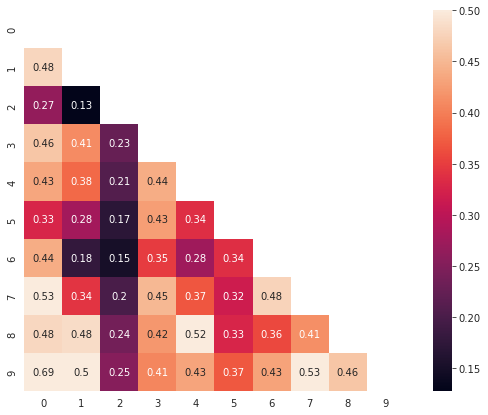

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel


tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-albert-small-v2')
model = AutoModel.from_pretrained('./multi_sim_output/sentence-transformers/paraphrase-albert-small-v2')

sim = sim_matrix(model)  # build similarity scores matrix
# visualize heatmap
mask = np.zeros_like(sim)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 7))
    ax = sns.heatmap(sim, annot=True, mask=mask, vmax=.5, square=True)

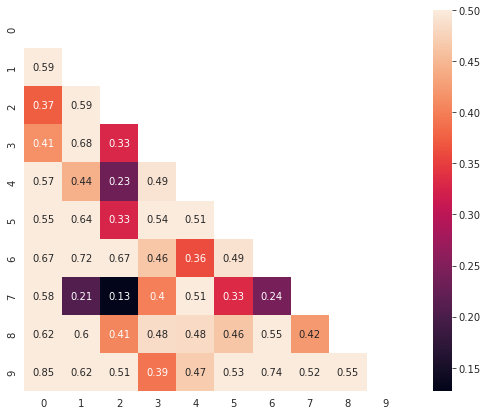

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel


tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/quora-distilbert-base')
model = AutoModel.from_pretrained('./multi_sim_output/sentence-transformers/quora-distilbert-base')

sim = sim_matrix(model)  # build similarity scores matrix
# visualize heatmap
mask = np.zeros_like(sim)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 7))
    ax = sns.heatmap(sim, annot=True, mask=mask, vmax=.5, square=True)